# Quantization in Depth

Quantization enables us to shrink models for better accessibility to the community.
Implement some quantization primitives from scratch, and also implement our own model quantizer and cover some challenges that anyone can face when it comes to lower bit quantization, such as weights packing.

**Model Compression:**
- Quantization: Store the parameters of the model in lower precision. (FP32 (-234.1 to 252.51) to INT8 (-128 to 127))
- Knowledge Distillation: Train a smaller (student) model using the original model (instructor)
- Pruning: Remove connections (weights) from the model to make the model more sparse.

- Theory: Common data types for ML (integer, floating point)
- Application: Perform linear quantization on any model using Hugging face quantum library in two lines.
- Overview of quantization applications on LLMs, finetuning.

**Fp32:**
- Sign: 1bit
- Exponent(range): 8bit
- Fraction(precision): 23 bit
- Total: 32 bit

**Course Outline:**
- Linear Quantization theory in detail and how to code their variants (per channel, per tensor, per group quantization), study the pros and cons for each of these methods, and see their impact on some random tensors.
- Build our own 8-bit linear quantizer using one of the quantization schemes and apply it on real models. (Note: Quantization scheme is agnostic to modalities, meaning you can apply it to any model as long as your model contains linear layers.) Technically, you'll be able to use your quantizer to quantize a vision, text, audio, or even a multimodel model. 
- Learn about quantization challenges when it comes to extreme quantization. (Weight packing, LLMs optimization)
- Pytorch doesn't have a native support for two-bit or four-bit precision weights. One way to address this issue is to pack these low precision weights into a higher precision tensor, for example INT8, and deep dive into that and implement packing and unpacking algorithms together.
- Review SOTA LLMs quantization methods.


Quantization refers to the process of mapping a large set to a smaller set of values. There are many quantization techiques such as (Linear and Non-linear, Clustering, Blockwise, Post-Training(PTQ), Per-Tensor, Per-Channel) Quantization, but here we are focusing only on linear quantization.

8-bit quantization: map values that are stored in torch.float32 to torch.int8 (e.g. vetween [-128, 127]).

**NN Quantization:**
Here you can quantize:
- The weights (NN parameters)
- The activations: Values that propagate through the layers of the NN.

If you quantize the NN after it has been trained, you are doing Post Training Quantization (PTQ).


**Advantages of Quantization:**
- Smaller model
- Speed gains
    - Memory bandwidth
    - Faster operations
        - GEMM: General Matrix Multiply (matrix to matrix multiplication)
        - GEMV: General Matrix Vector Multiplication (matrix to vector multiplication)

**Challenges of Quantization:**
- Quantization error
- Retraining (Quantization Aware Training (QAT))
- Limited Hardware Support
- Calibration dataset needed
- packing/unpacking

**Theory of Linear Quantization:**
- Linear Quantization uses a linear mapping to map the higher precision range. For e.g. FP3232 to a lower precision range for e.g. INT8.
- There are two parameters in a linear quantization:
    - We have the scale S and the zero point z.
    - The scale is stored in the same data type as the original tensor and z is stored in the same datatype as the quantized tensor.
- Formula: r = s(q-z)
- Here s = scale (e.g. in FP32) and z = zero point (e.g. INT8)
- Example with s=2 and z=0:
  - we get: r = 2(q-0) = 2q
  - For q=10, we have r = 2*10 = 20
- Isolate q in order to get the dequantized value: q = int(round(r/s+z))
- Getting q:
    - r = s(q-z)
    - r/s = q-z
    - (r/s)+z = q
    - q = round((r/s)+z)
    - q = int(round((r/s)+z) #typecasting

# L2-A - Linear Quantization I: Quantize and De-quantize a Tensor

The libraries are already installed in the classroom.  If you're running this notebook on your own machine, you can install the following:

```Python
!pip install torch==2.1.1
```

In [1]:
import torch

## Quantization with Random `Scale` and `Zero Point`

- Implement Linear Quantization for when the "scale" and the "zero point" are known/randomly selected.

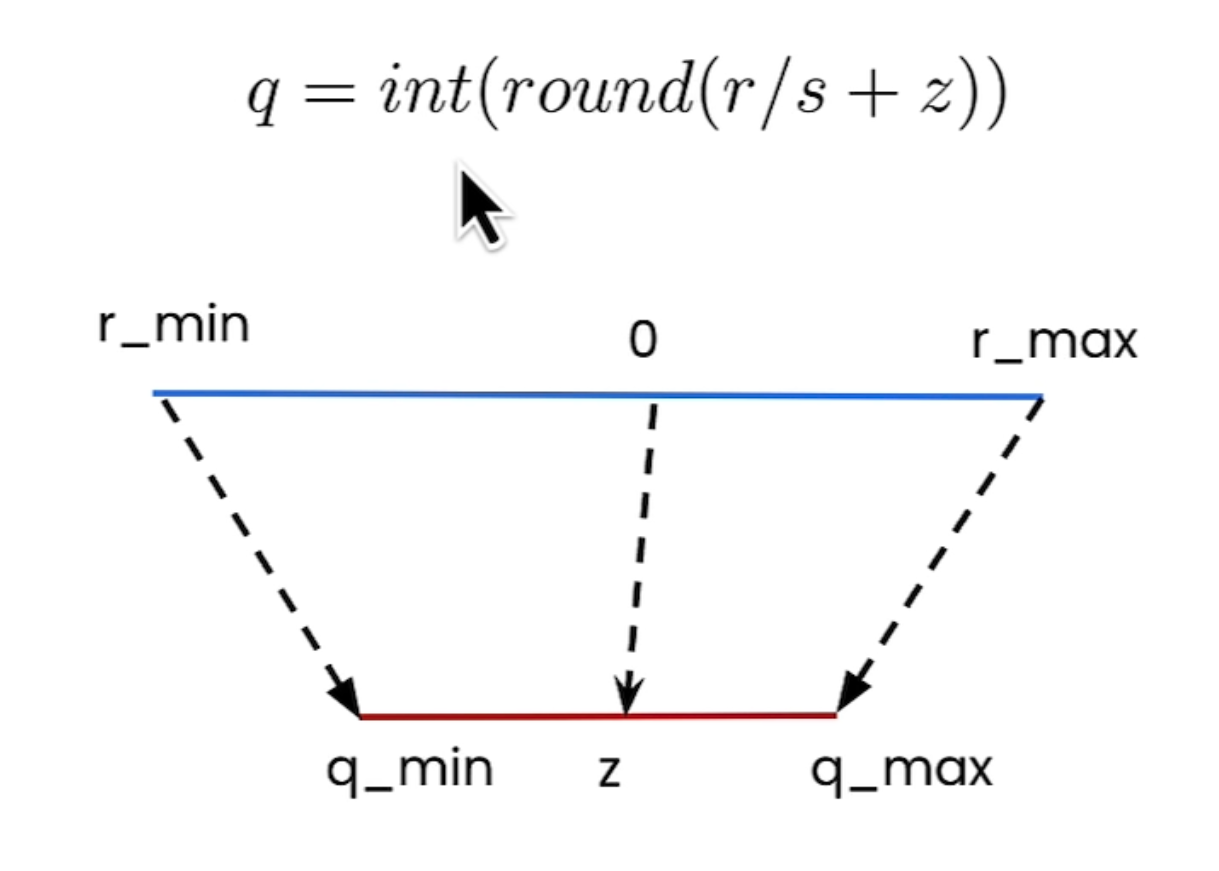

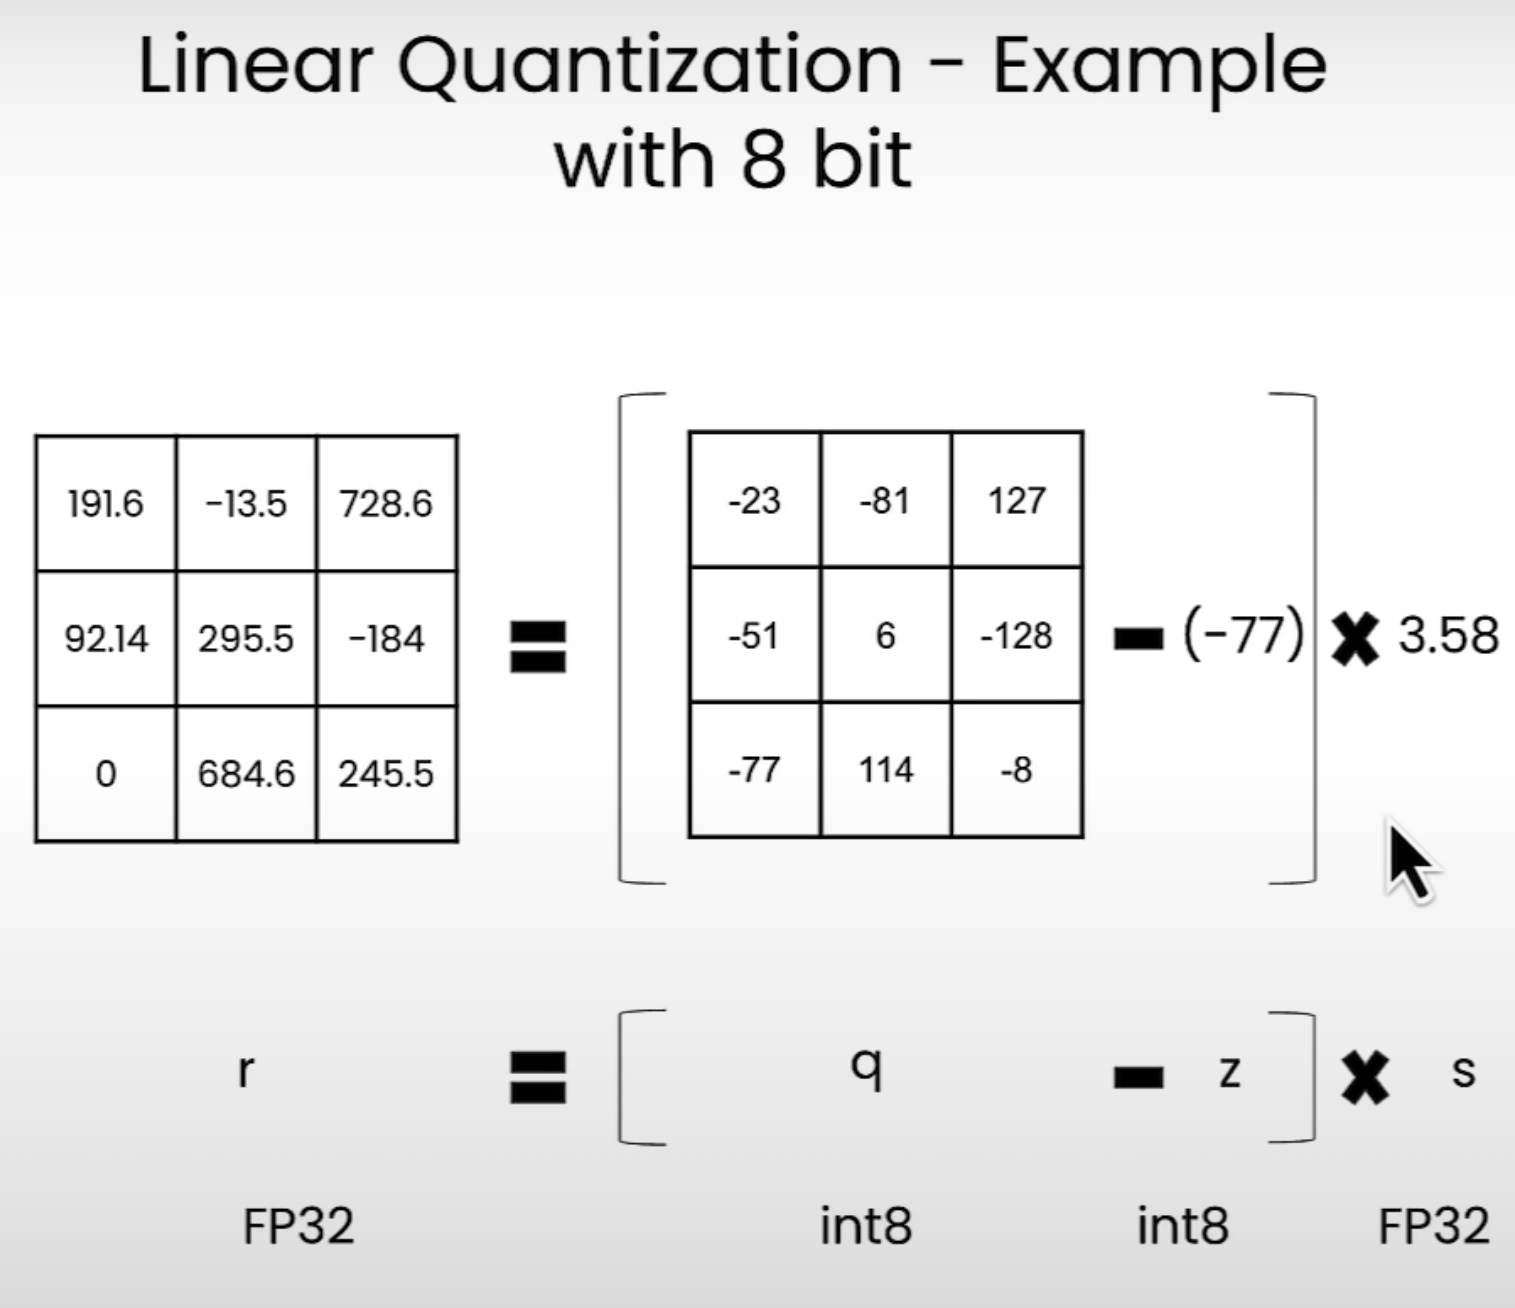

In [2]:
from IPython.display import Image, display
display(Image(filename='image1.png'))
display(Image(filename='image2.png'))

In [3]:
def linear_q_with_scale_and_zero_point(
    tensor, scale, zero_point, dtype = torch.int8):

    scaled_and_shifted_tensor = tensor / scale + zero_point

    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    # Minimum and maximum quantized value
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    # torch.clamp() constrains the elements of a tensor within a specified range. Takes an input tensor and clamps all its elements to be within the range defined by the min and max values provided.
    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    
    return q_tensor

In [4]:
### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [5]:
### these are random values for "scale" and "zero_point"
### to test the implementation
scale = 3.5
zero_point = -70

In [6]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, scale, zero_point)

In [7]:
quantized_tensor

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)

## Dequantization with Random `Scale` and `Zero Point`

- Now, Dequantize the tensor to see how precise the quantization is.

In [8]:
dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

In [9]:
# this was the original tensor
# [[191.6, -13.5, 728.6],
#  [92.14, 295.5,  -184],
#  [0,     684.6, 245.5]]

In [10]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

In [11]:
### without casting to float
scale * (quantized_tensor - zero_point)

tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])

In [12]:
def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

- Calculate `dequantized_tensor` using the function `linear_dequantization`.

In [13]:
dequantized_tensor = linear_dequantization(
    quantized_tensor, scale, zero_point)

- Print the results of the `dequantized_tensor`.

In [14]:
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

### Quantization Error

- Load the `plot_quantization_errors` from the helper file.
- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [15]:
from helper import plot_quantization_errors

- Plot the quantization results.

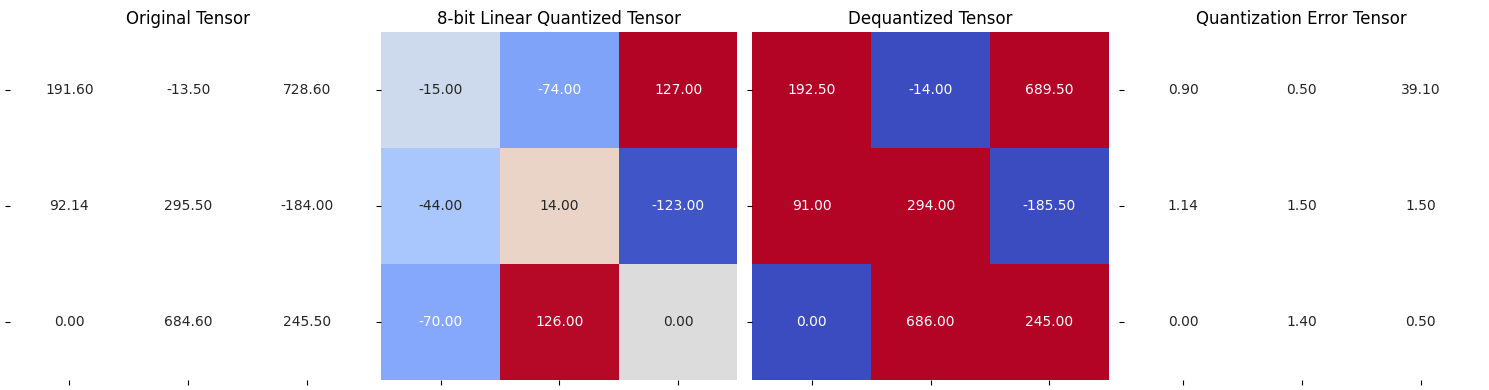

In [16]:
plot_quantization_errors(test_tensor, quantized_tensor,
                         dequantized_tensor)

**Note:** For the plot above, `Quantization Error Tensor = abs(Original Tensor - Dequantized Tensor)`

- Calculate an "overall" quantization error by using [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) technique.

In [17]:
dequantized_tensor - test_tensor

tensor([[  0.9000,  -0.5000, -39.1000],
        [ -1.1400,  -1.5000,  -1.5000],
        [  0.0000,   1.4000,  -0.5000]])

In [18]:
(dequantized_tensor - test_tensor).square()

tensor([[8.0999e-01, 2.5000e-01, 1.5288e+03],
        [1.2996e+00, 2.2500e+00, 2.2500e+00],
        [0.0000e+00, 1.9601e+00, 2.5000e-01]])

In [19]:
(dequantized_tensor - test_tensor).square().mean()

tensor(170.8753)

The quantization error = 170.8753 is quite high because in this example we assign a random value to scale and zero points. Next, we will find out those optimal values.